In [2]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
from scipy import stats 
import IS as isfn
import network_mod as netfn
import matplotlib
import powerlaw
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.7.6 (default, Jan  8 2020, 13:42:34) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

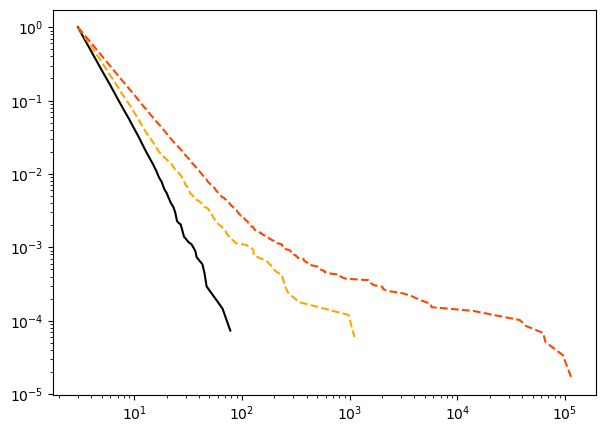

In [3]:
# Choose path and create lists of coord and trace files

# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_randbase*av.npy*'))
prelist = sorted(glob.glob('*PTZ20*_preictal*av.npy*'))
p20list = sorted(glob.glob('*PTZ20*_ictal*av.npy*'))

choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
pre_distlist = [np.load(prelist[i])[choose] for i in range(len(prelist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
pre_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    pre_vec = np.append(pre_vec, pre_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])
    
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (5,3))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k')
sns.reset_orig()
avdistcut = pre_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =1.5 , markersize = 1, alpha = 1, c = 'orange')
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =1.5 , markersize = 1, alpha = 1, c = 'orangered')

plt.show()

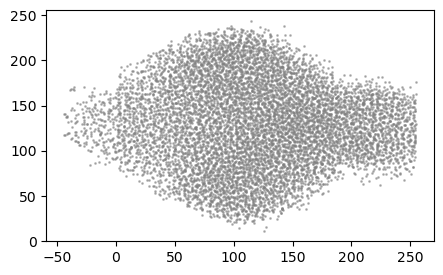

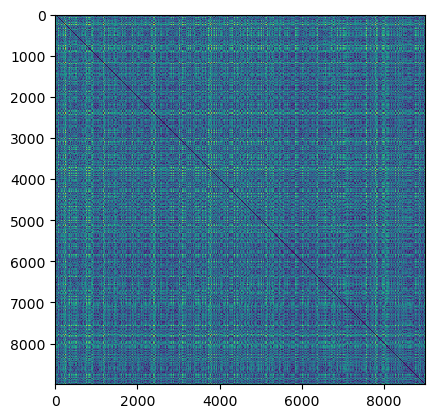

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)

node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (5,3))
nodes = np.load(node[0])
net_nnb = np.load(sorted(glob.glob('*net_model_nnb*'))[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 1, color = 'grey' , alpha = 0.5)
plt.show()

dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

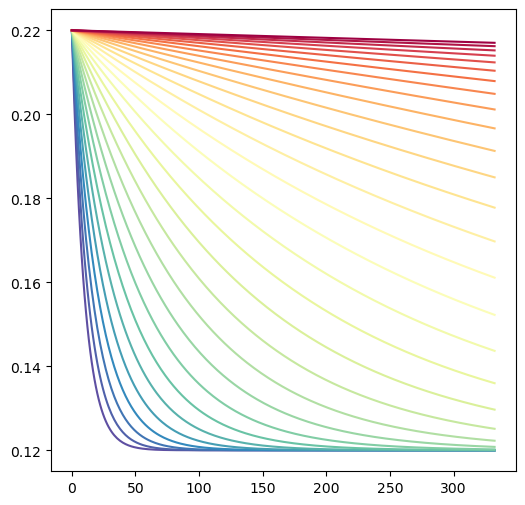

In [5]:
#Two parameters - one for scaling (s) + one for relaxing (r)
# Conversion from distance to edge weights, scaled (itself exponentially) by s
#s = 1.2, soften = 0.1, divisor = 10
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, r,s):
    edgeweights = (s + np.exp(-soften/np.exp(r)*distance))/divisor
    return edgeweights

#S parameters
Nsteps  = 30
divisor = 10
soften = 0.1
r_vals   = np.array(np.linspace(0, 7, Nsteps)).tolist()
s = 1.2
#Plot each s value
fig, ax = plt.subplots(1, figsize=(6,6))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for r in range(len(r_vals)):
    ax.plot(distance, dist2edge(distance, divisor, r_vals[r], s), c=colors[r])
#ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [31]:
import brian2 as b2
from random import sample
from numpy import random

## LIF PARAMETERS
#Network dynamics
sim_time = 400
N = nodes.shape[0] 
v_rest= 0 #Resting potential
t_syn_del = 1 * b2.ms #delay between presynaptic spike and postsynaptic increase
tau_l = 20. * b2.ms #leak time constant - time taken for voltage to reach 63% of resting value
s = 1.2 #Synaptic weights

#External input
N_e = 1000 #number of presynaptic excitatory poisson neurons 
lam = 10 * b2.Hz #poisson rate of external population
w_e= 0.1  #synaptic weight of excitatory external possion neurons onto all neurons 

In [ ]:
#Brute force - granular sweep
from scipy.optimize import brute
from scipy import stats

total_list = []
def cost(params):
    print(params)  # <-- you'll see that params is a NumPy array
    k, v_th, r  = params # <-- for readability you may wish to assign names to the component variables
    bind, spikes, volt = netfn.run_net(sim_time, int(k), v_th, r, s, divisor, soften, N, dist, v_rest, t_syn_del, tau_l, N_e, lam, w_e)
    av,pkg = crfn.avalanche_r(net_nnb, bind)
    cost_max, cost_mean = netfn.ks_log(av[0], bln_vec)
    total_list.append([params, cost_max, av])
    print('cost = ' + str(cost_max))
    return cost_max

#Define params
ranges = (slice(5, 40, 1), slice(15, 20, 1), slice(0, 7, 1))
result = brute(cost, ranges)

[ 5 15  0]
cost = 0.9288567458626682
[ 5 15  1]
cost = 1.078685167243433
[ 5 15  2]
cost = 0.982975058700446
[ 5 15  3]
cost = 1.1164982209553242
[ 5 15  4]
cost = 1.0433109798803124
[ 5 15  5]
cost = 1.1220219741943867
[ 5 15  6]
cost = 1.113405264724952
[ 5 16  0]
cost = 1.273128659167944
[ 5 16  1]
cost = 1.3429749616689048
[ 5 16  2]
cost = 1.3283199035937163
[ 5 16  3]
cost = 1.0055761716343259
[ 5 16  4]
cost = 1.0495939221505926
[ 5 16  5]
cost = 0.9014817578183836
[ 5 16  6]
cost = 1.0488297226187209
[ 5 17  0]
cost = 0.8887766253058262
[ 5 17  1]
cost = 0.9537560526506623
[ 5 17  2]
cost = 0.858473942526095
[ 5 17  3]
cost = 1.3597549292830107
[ 5 17  4]
cost = 1.1200520343801021
[ 5 17  5]
cost = 1.2919653441212091
[ 5 17  6]
cost = 1.23626302834648
[ 5 18  0]
cost = 1.2066361664073515
[ 5 18  1]
cost = 0.7887619709546949
[ 5 18  2]
cost = 0.8183438579169859
[ 5 18  3]
cost = 0.8246204641774026
[ 5 18  4]
cost = 1.1835421790575147
[ 5 18  5]
cost = 1.2647690011914978
[ 5 18  

In [10]:
#Starting points - initial guess
k_0 = 15
v_th_0 = 20
r_0 = 1

In [ ]:
#KS distance
from scipy.optimize import minimize
from scipy import stats
total_list = []
def cost(params):
    print(params)  # <-- you'll see that params is a NumPy array
    k, v_th, r  = params # <-- for readability you may wish to assign names to the component variables
    bind, spikes, volt = netfn.run_net(sim_time, int(k), v_th, r, s, divisor, soften, N, dist, v_rest, t_syn_del, tau_l, N_e, lam, w_e)
    av,pkg = crfn.avalanche_r(net_nnb, bind)
    cost_max, cost_mean = netfn.ks_log(av[0], pre_vec)
    total_list.append([params, cost_mean, av])
    print('cost = ' + str(cost_mean))
    return cost_mean

#Define params
initial_guess = [k_0, v_th_0, r_0]
bnds = ((5,40), (15, 22), (0, 7))
result = minimize(cost, initial_guess, bounds = bnds, method = 'Powell')

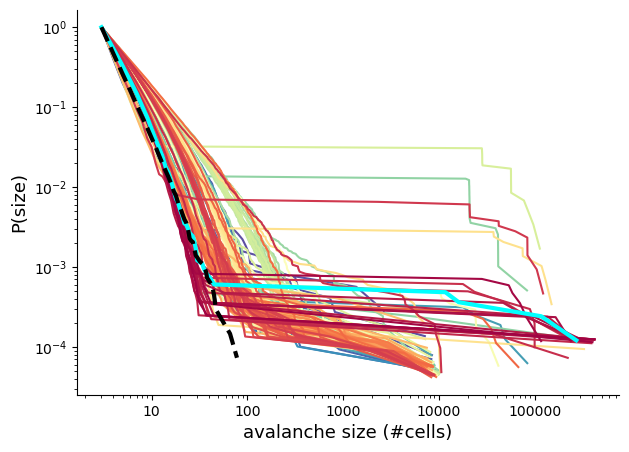

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2][0]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2][0]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [14]:
os.chdir(Fdrop + 'Project/' + experiment)

costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]
    
#np.save('optimise_brute_ksdistlow_ba_blnf1_params.npy',   paramlist)
#np.save('optimise_brute_ksdistlow_ba_blnf1_cost.npy',    costlist)
#np.save('optimise_brute_ksdistlow_ba_blnf1_avs.npy',  avlist)

print('iterations = ' + str(len(costlist)) + '  true min = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
true_min = np.where(costlist == np.min(costlist))[0][0]
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 201  true min = 38
min cost = 0.0869288926606046
min params = [35.32349764 20.36942756  1.        ]


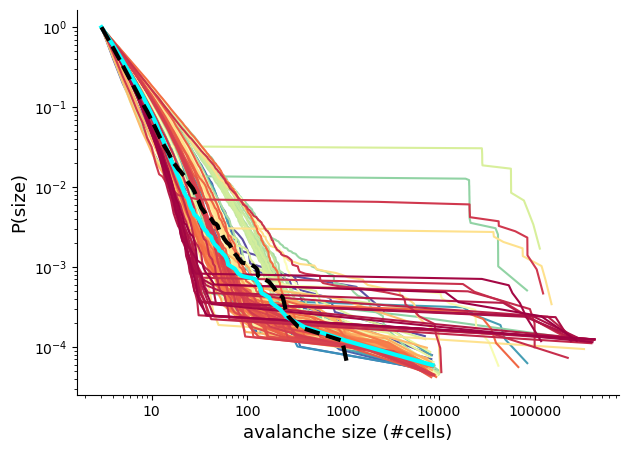

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2][0]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[true_min][2][0]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = pre_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def exp_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0,  divisor, soften, cutoff, n_sims, 1).av_size
    
    
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
ranges = (slice(0, 15, 0.1), slice(2, 10, 1))
result = brute(ks_dist, ranges)

In [20]:
avs = prac
binvec = np.append(empirical,avs)
mini = np.min(binvec)
maxi = np.max(binvec)
bins = 1000
model_hist = axarr.hist(avs, bins=bins, range = (mini, maxi), density=True, histtype='step', linewidth = 1.5, cumulative=-1)
model_xaxis = np.log10(model_hist[1])
model_yaxis = np.log10(model_hist[0])

emp_hist = axarr.hist(empirical, bins=bins, range = (mini, maxi), density=True, histtype='step', linewidth = 1.5, cumulative=-1)
emp_xaxis = np.log10(emp_hist[1])
emp_yaxis = np.log10(emp_hist[0])
#xstop = np.where(model_yaxis == float("-inf"))[0][0]
#cost = np.linalg.norm(emp_yaxis[:xstop] - model_yaxis[:xstop])


<ipython-input-20-56350228772d>:8: RuntimeWarning: divide by zero encountered in log10
  model_yaxis = np.log10(model_hist[0])


In [ ]:
slope =  -1*stats.linregress(np.log10(xaxis[:len(xaxis)-1][1:]),np.log10(yaxis[:len(xaxis)-1][1:]))[0]

<ipython-input-26-08818574b7f0>:7: RuntimeWarning: divide by zero encountered in log10
  yaxis = np.log10(hist[0]/np.sum(hist[0]))


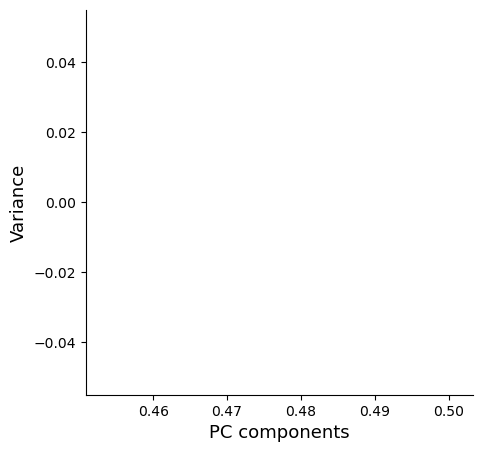

In [26]:
fig, axarr = plt.subplots(figsize = (5,5))

avdistcut = prac
binned=np.linspace(mini,maxi, 67)
hist = np.histogram(avdistcut, bins = binned)
xaxis = np.log10(hist[1][:-1])
yaxis = np.log10(hist[0]/np.sum(hist[0]))
axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)


axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

axarr.set_ylabel('Variance', size = '13')
axarr.set_xlabel('PC components', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


In [ ]:
avs = prac
binvec = np.append(empirical,avs)
mini = np.min(binvec)
maxi = np.max(binvec)
bins = 1000000
model_hist = axarr.hist(avs, bins=bins, range = (mini, maxi), density=True, histtype='step', linewidth = 1.5, cumulative=-1)
model_xaxis = np.log10(model_hist[1])
model_yaxis = np.log10(model_hist[0])
m,c = np.polyfit(np.log10(xaxis[:len(xaxis)-1][1:]), np.log10(yaxis[:len(xaxis)-1][1:]), 1)
y_fit = np.exp(m*(np.log10(xaxis[:len(xaxis)-1])) + c) # calculate the fitted values of y 
plt.plot(xaxis[:len(xaxis)-1], y_fit[:len(xaxis)-1])


In [ ]:
#Parameter sweep
from scipy.optimize import minimize
from scipy.optimize import brute
from scipy import stats
total_list = []
def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.ba_netsim(dist).simulate(s, int(k), 0,  divisor, soften, cutoff, n_sims, 1).av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    total_list.append([params, ks, avs])
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
ranges = (slice(0, 15, 0.1), slice(2, 10, 1))
result = brute(ks_dist, ranges)

In [87]:
result

array([ 3.33932874, 21.71079496])

In [11]:
os.chdir(Fdrop + 'Project/' + experiment)

costlist, paramlist, avlist = list(range(len(total_list))), list(range(len(total_list))), list(range(len(total_list)))
for i in range(len(total_list)):
    paramlist[i] = total_list[i][0]
    costlist[i] = total_list[i][1]
    avlist[i] = total_list[i][2]
    
np.save('optimise_brute_ksdistlow_ba_blnf1_params.npy',   paramlist)
np.save('optimise_brute_ksdistlow_ba_blnf1_cost.npy',    costlist)
np.save('optimise_brute_ksdistlow_ba_blnf1_avs.npy',  avlist)

print('iterations = ' + str(len(costlist)) + '  true min = ' + str(np.where(costlist == np.min(costlist))[0][0]))
print('min cost = ' + str(costlist[np.where(costlist == np.min(costlist))[0][0]]))
print('min params = ' + str(paramlist[np.where(costlist == np.min(costlist))[0][0]]))
curr = avlist[np.where(costlist == np.min(costlist))[0][0]]

iterations = 1601  true min = 1510
min cost = 0.00806875683292052
min params = [8.85222392 5.06457948]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba+*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba+*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba+*params.npy'))
avlist, costlist, paramlist

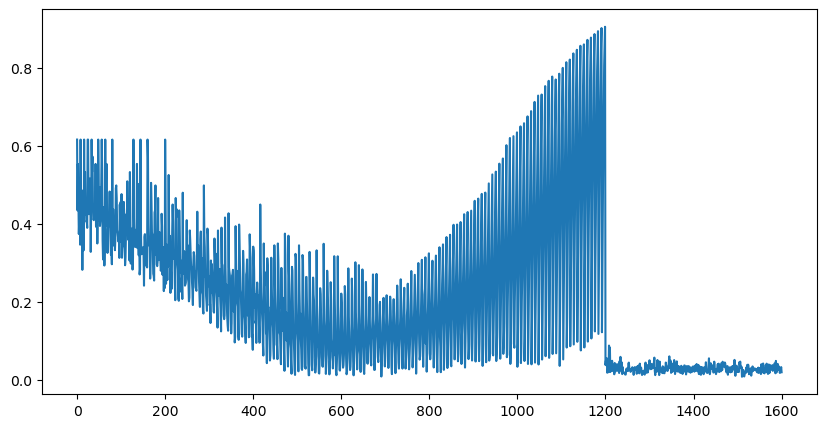

In [13]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

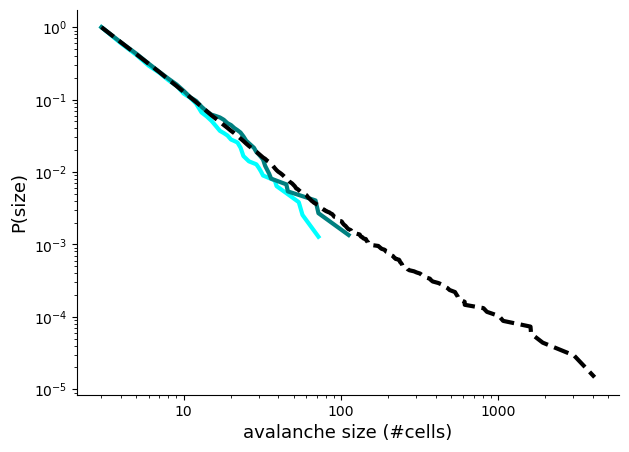

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

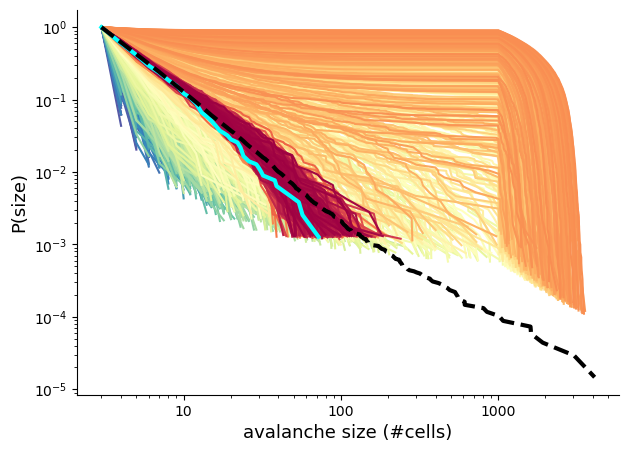

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba+*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba+*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba+*params.npy'))
avlist, costlist, paramlist

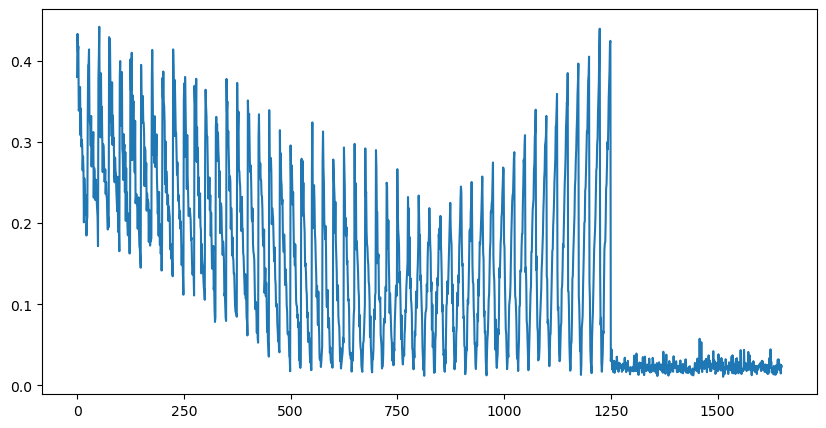

In [89]:
fig = plt.figure(figsize= (10,5))
plt.plot(np.arange(0, len(costlist)), costlist)
plt.show()

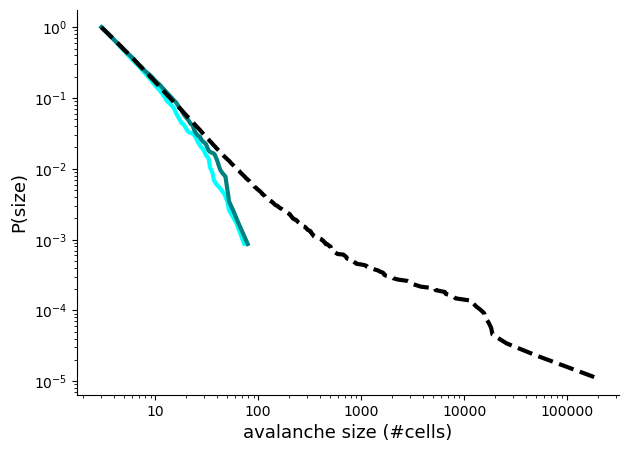

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   

avdistcut = avlist[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = avlist[np.where(costlist == np.min(costlist))[0][0]]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'teal')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

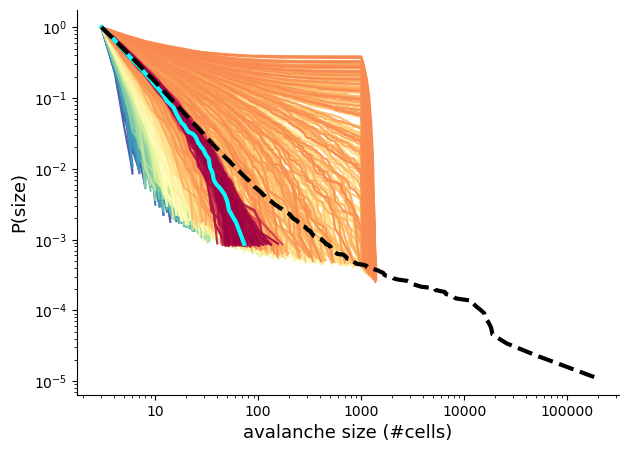

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy
os.chdir(F10t + 'Project/' + experiment)


colors = cm.Spectral_r(np.linspace(0, 1, len(total_list)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
for i in range(len(total_list)):
    av_dense = total_list[i][2]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
    

avdistcut = total_list[-1][2]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'cyan')

avdistcut = empirical
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
avlist = sorted(glob.glob('optimise*ks*ba_*avs.npy'))
costlist = sorted(glob.glob('optimise*ks*ba_*cost.npy'))
paramlist = sorted(glob.glob('optimise*ks*ba_*params.npy'))
avlist, costlist, paramlist

(['optimise_brute_ksdist_ba_blnf1_avs.npy',
  'optimise_brute_ksdist_ba_p20f1_avs.npy'],
 ['optimise_brute_ksdist_ba_blnf1_cost.npy',
  'optimise_brute_ksdist_ba_p20f1_cost.npy'],
 ['optimise_brute_ksdist_ba_blnf1_params.npy',
  'optimise_brute_ksdist_ba_p20f1_params.npy'])

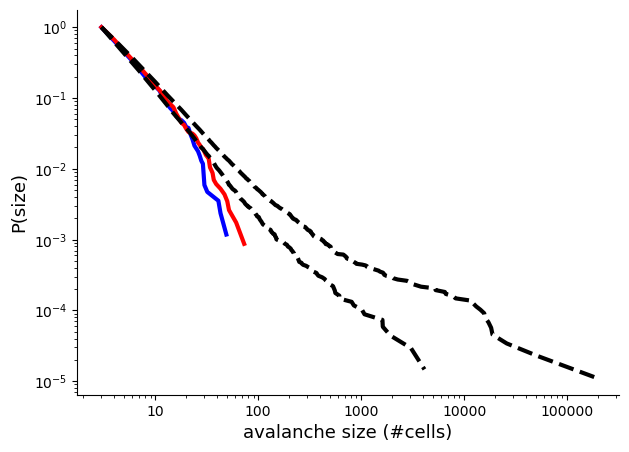

baseline = [ 4.19261721 14.67675784]
ptz = [ 3.33932874 21.71079496]


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = np.load(avlist[0], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = np.load(avlist[1], allow_pickle=True)[-1]
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[-1]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[-1]))

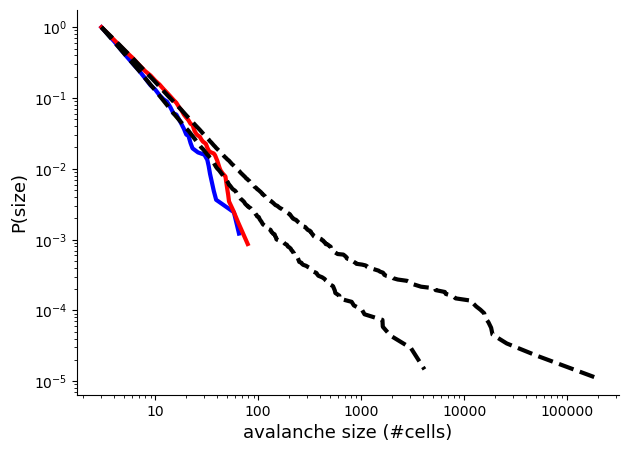

baseline = [ 4.19261721 14.67675784]
ptz = [ 3.33932874 21.71079496]


In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

import matplotlib
import powerlaw


bln_curr = np.load(avlist[0], allow_pickle=True)[np.where(np.load(costlist[0]) == np.min(np.load(costlist[0])))[0][0]]
ptz_curr = np.load(avlist[1], allow_pickle=True)[np.where(np.load(costlist[1]) == np.min(np.load(costlist[1])))[0][0]]

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
avdistcut = bln_curr
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'blue')

avdistcut = ptz_curr
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =3 , markersize = 3, alpha = 1, c = 'red')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')

avdistcut =p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =3 , markersize = 3, alpha = 1, c = 'k')
        
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)

plt.show()

print('baseline = ' + str(np.load(paramlist[0], allow_pickle=True)[np.where(np.load(costlist[0]) == np.min(np.load(costlist[0])))[0][0]]))
print('ptz = ' + str(np.load(paramlist[1], allow_pickle=True)[np.where(np.load(costlist[1]) == np.min(np.load(costlist[1])))[0][0]]))